In [2]:
import os
import numpy as np
import pickle
import cv2
import random
# from numpy.linalg import inv
import matplotlib.pyplot as plt

print(f"numpy version: {np.__version__}")
print(f"pickle version: {pickle.format_version}")
print(f"cv2 version: {cv2.__version__}")

numpy version: 1.23.3
pickle version: 4.0
cv2 version: 4.6.0


# generate train/val/test image pairs

In [23]:
PATCH_SIZE = 128
NORM_FACTOR = np.sqrt(PATCH_SIZE**2 + PATCH_SIZE**2)
# MAX_TRANSLATION = int(PATCH_SIZE / 4)
MAX_TRANSLATION = 0
MAX_ROTATION = 180

In [44]:
def get_random_translation(length):
    alpha = np.radians(random.randint(0, 360))
    length = random.uniform(0, length)
    x = np.cos(alpha)
    y = np.sin(alpha)
    if y == 0.0:
        x_scaling = length
        y_scaling = 0
    elif x == 0.0:
        x_scaling = 0
        y_scaling = length
    else:
        x_scaling = (y/x)*length
        y_scaling = (x/y)*length
    return [x * x_scaling, y * y_scaling]

def rigid_transformation(point, middle, translation, rotation):
        point = [point[0] - middle[0], point[1] - middle[1]]
        A = np.array([[np.cos(rotation), -1 * np.sin(rotation)],
                    [np.sin(rotation), np.cos(rotation)]])
        t = np.array(translation)

        point_trf = np.matmul(A, point) + t
        point_trf = point_trf[0] + middle[0], point_trf[1] + middle[1]
        return point_trf

def generate_image_pair(image, path, max_translation, max_rotation):
    img = cv2.imread(path + "/" + image, 0)
    image_size = (img.shape[1], img.shape[0])
    # downscale image by factor 2
    img = cv2.resize(img, (int(image_size[0]/2), int(image_size[1]/2)))
    image_size = (img.shape[1], img.shape[0])
    reference_image = img.copy()

    middle_point = (np.asarray(image_size) / 2).astype('int')
    top_left_point = (middle_point[0]-(int(PATCH_SIZE/2)), middle_point[1]-(int(PATCH_SIZE/2)))
    bottom_left_point = (middle_point[0]-(int(PATCH_SIZE/2)), middle_point[1]+(int(PATCH_SIZE/2)))
    bottom_right_point = (middle_point[0]+(int(PATCH_SIZE/2)), middle_point[1]+(int(PATCH_SIZE/2)))
    top_right_point = (middle_point[0]+(int(PATCH_SIZE/2)), middle_point[1]-(int(PATCH_SIZE/2)))
    corner_points = [top_left_point, bottom_left_point, bottom_right_point, top_right_point]

    angle = random.randint(-MAX_ROTATION, MAX_ROTATION)
    translation = get_random_translation(max_translation)
    
    corner_points_transformed = []
    for point in corner_points:
        corner_points_transformed.append(rigid_transformation(point, middle_point, translation, np.radians(angle)))

    # check if transformed points are within reference image
    if (np.asarray(corner_points_transformed)[:, 0] <= image_size[0]).all() and (np.asarray(corner_points_transformed)[:, 0] >= 0).all() and (np.asarray(corner_points_transformed)[:, 1] <= image_size[1]).all() and (np.asarray(corner_points_transformed)[:, 1] >= 0).all():
        pass
    else:
        return None

    H = cv2.getPerspectiveTransform(np.float32(corner_points), np.float32(corner_points_transformed))
    H_inverse = np.linalg.inv(H)
    warped_image = cv2.warpPerspective(img,H_inverse, image_size)

    image_0 = reference_image[top_left_point[1]:bottom_right_point[1], top_left_point[0]:bottom_right_point[0]]
    image_1 = warped_image[top_left_point[1]:bottom_right_point[1], top_left_point[0]:bottom_right_point[0]]
    
    H_four_point = np.subtract(np.array(corner_points_transformed), np.array(corner_points))

    # normalize
    H_four_point = H_four_point / NORM_FACTOR

    image_pair = np.dstack((image_0, image_1))
    if image_pair.shape == (PATCH_SIZE, PATCH_SIZE, 2):
        # return (image_pair, H_four_point, translation, angle)
        return (image_pair, H_four_point)
    else:
        return None

def save_image_pairs(path):
    lst = os.listdir(path + '/')
    data = []
    skipped_images = 0
    number_images = 0
    for image in lst:
        datum = generate_image_pair(image, path, MAX_TRANSLATION, MAX_ROTATION)
        if not datum is None: 
            data.append(datum)
        else:
            skipped_images += 1
        number_images += 1
    with open(path + "_processed.pickle", "wb") as f:
        pickle.dump(data, f)
    # print(skipped_images / number_images)

In [45]:
data_path = "data/"
train_path = data_path + "train2014/train2014"
val_path = data_path + "val2014/val2014"
test_path = data_path + "test2014/test2014"

save_image_pairs(train_path)
save_image_pairs(val_path)
save_image_pairs(test_path)

# inspect data

In [46]:
def rot_from_mat(mat):
    return np.arctan2(mat[1,0], mat[0,0])

def translation_from_mat(mat):
    return [mat[0][2], mat[1][2]]

def four_point_to_transformation(H_four_point):
    top_left_point  = np.array([-int(PATCH_SIZE/2), -int(PATCH_SIZE/2)])
    bottom_left_point = np.array([-(int(PATCH_SIZE/2)), int(PATCH_SIZE/2)])
    bottom_right_point = np.array([int(PATCH_SIZE/2), int(PATCH_SIZE/2)])
    top_right_point  = np.array([int(PATCH_SIZE/2), -int(PATCH_SIZE/2)])

    M = cv2.getPerspectiveTransform(np.float32([top_left_point, bottom_left_point, bottom_right_point, top_right_point]), np.float32([top_left_point + H_four_point[0], bottom_left_point + H_four_point[1], bottom_right_point + H_four_point[2], top_right_point + H_four_point[3]]))

    translation = translation_from_mat(M)
    rotation = rot_from_mat(M)

    return translation, rotation

In [56]:
with open(os.path.join(train_path + "_processed.pickle"), "rb") as f:
    train_data = pickle.load(f)
print(len(train_data))

78775


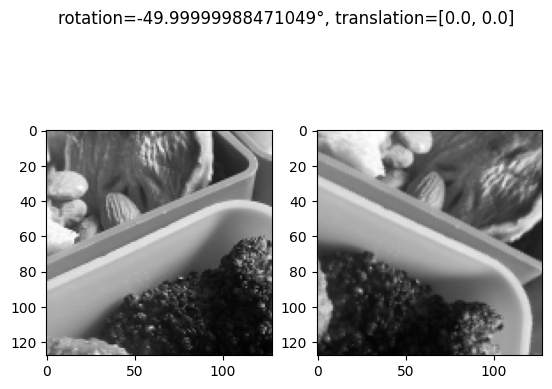

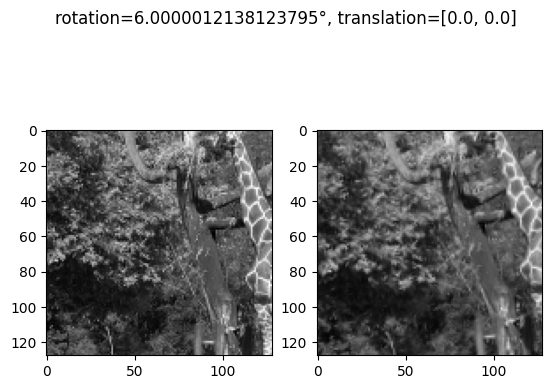

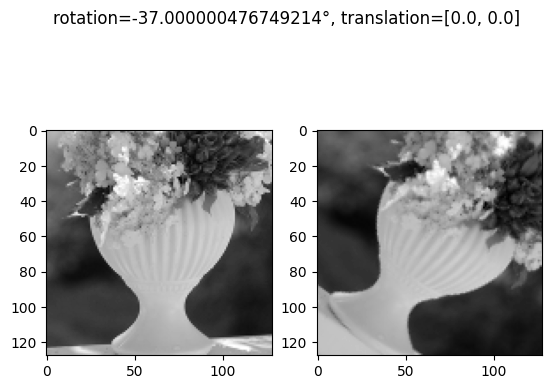

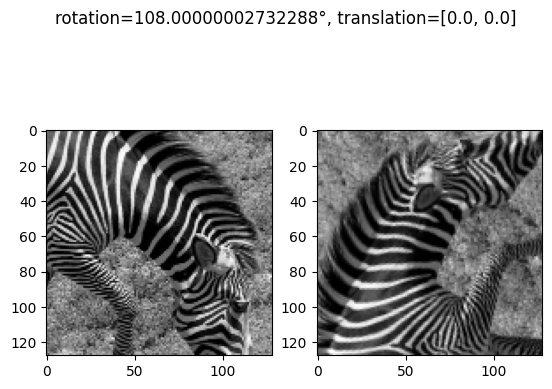

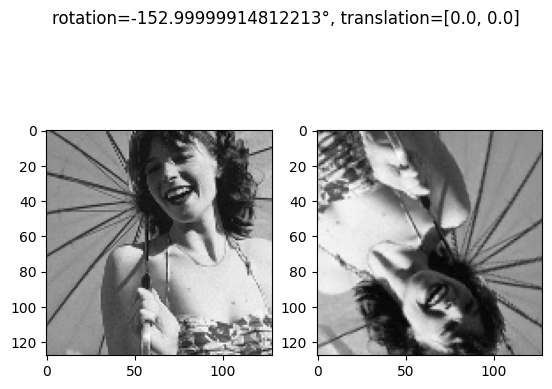

In [55]:
# plot sample pairs
for sample_id in range(5):
    sample_image_pair = train_data[sample_id][0]
    sample_H_four_point = train_data[sample_id][1]
    sample_transformation = four_point_to_transformation(train_data[sample_id][1] * NORM_FACTOR)
    sample_translation = sample_transformation[0]
    sample_angle = sample_transformation[1]

    fig, axs = plt.subplots(1, 2)
    fig.suptitle(f"rotation={np.degrees(sample_angle)}°, translation={sample_translation}")
    axs[0].imshow(sample_image_pair[:, :, 0], cmap="gray")
    axs[1].imshow(sample_image_pair[:, :, 1], cmap="gray")

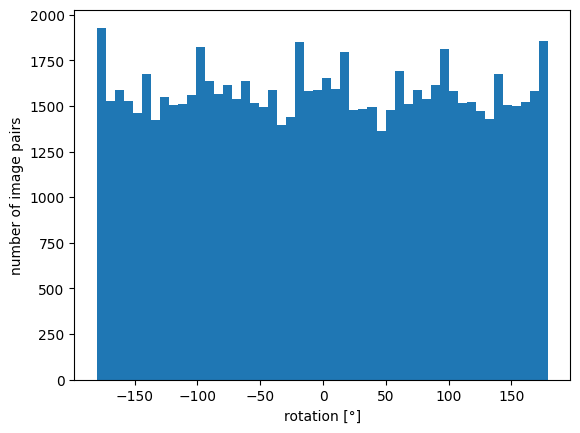

In [52]:
# plot rotation distribution
rotations = []

for i in range(len(train_data)):
    sample_transformation = four_point_to_transformation(train_data[i][1] * NORM_FACTOR)
    rotations.append(np.degrees(sample_transformation[1]))

plt.hist(rotations, bins=50)
plt.xlabel("rotation [°]")
plt.ylabel("number of image pairs")
plt.show()